In [488]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calplot
import validators

In [489]:
sns.set_theme()

# Feature Selection for Clustering of Telegram Chats 

# Load the data

We import the data and drop the duplicated index column "Unnamed: 0". 

**Due to the size of the dataset, this might take some time.**

In [490]:
path = os.path.join(os.getcwd(), '../data/csv/freiesth_scrape_2.csv')
df = pd.read_csv(path, low_memory=False)
df.drop(labels="Unnamed: 0", axis=1, inplace=True)

# Initial Exploration

Now, we can start exploring the data by...

1. Inspecting column types.

2. Inspecting column values.

3. Searching the dataframe for missing datapoints.

4. Check for duplicate rows.

5. Verify dates.

6. Verify webpages.

7. Checking the distribution of messages across chats. 

### 1. Inspect column types

First, we inspect the column types to see if they match the data contained in them.


In [491]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1959797 entries, 0 to 1959796
Data columns (total 31 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   chat_handle              object 
 1   chat_name                object 
 2   chat_type                object 
 3   collection_time          object 
 4   fwd_from_chat_handle     object 
 5   fwd_from_user_name       object 
 6   is_fwd                   bool   
 7   is_group_elem            bool   
 8   is_reply                 bool   
 9   message_date             object 
 10  message_fwd_count        float64
 11  message_group_id         float64
 12  message_media_type       object 
 13  message_reactions        object 
 14  message_reactions_count  float64
 15  message_text             object 
 16  message_view_count       float64
 17  post_author              float64
 18  reply_to_message_id      float64
 19  reply_to_top_message_id  float64
 20  sender_display_name      float64
 21  sender_f

There are some columns that don't match the type of the data contained in them:
- `post_author`: Is `float64`, should be `object`.
- `sender_display_name`: Is `float64`, should be `object`.
- `collection_time`: Is `object`, should be `datetime`.
- `message_date`: Is `object`, should be `datetime`.

### 2. Inspect column values

To get a feeling for the data and to weed out obvious inconsistencies, we can inspect the unqiue values for each column. 

1. First, we'll take a look at the number of unique values per column. This way we can get a feeling for which columns we can reasonably inspect manually.

2. Afterwards, we'll display the  values for each column with less or equal to 20 unique values and inspect them.

In [492]:
unique_values_per_column = df.nunique()
pd.DataFrame(unique_values_per_column, columns=["Unique values"])

,Unique values
chat_handle,4899
chat_name,4969
chat_type,2
collection_time,207393
fwd_from_chat_handle,8168
fwd_from_user_name,944
is_fwd,2
is_group_elem,2
is_reply,2
message_date,1590999


In [493]:
under_20 = unique_values_per_column[unique_values_per_column<=20]

for column in under_20.index:
    print(f"{df[column].value_counts()}\n")

chat_type
broadcast    1893133
megagroup      66664
Name: count, dtype: int64

is_fwd
False    1432670
True      527127
Name: count, dtype: int64

is_group_elem
False    1645573
True      314224
Name: count, dtype: int64

is_reply
False    1886155
True       73642
Name: count, dtype: int64

message_media_type
MessageMediaPhoto               830857
MessageMediaDocumentVideo       569327
MessageMediaWebPage             287285
MessageMediaDocumentAudio        43383
MessageMediaDocumentPhoto        18026
MessageMediaDocumentDocument     16989
MessageMediaPoll                  2315
MessageMediaStory                   86
MessageMediaContact                 44
MessageMediaDocumentOther           40
MessageMediaDocument                26
MessageMediaGeo                     18
MessageMediaGiveaway                18
MessageMediaInvoice                  7
MessageMediaDice                     6
MessageMediaGiveawayResults          4
MessageMediaUnsupported              4
Name: count, dtype: int64


**Findings**:

- As we can see, many columns have a high degree of unique values. This high cardinality is expected due to the inherently variable nature of Telegram messages.


- For some columns with high cardinality, the variability might be influenced by how the data is stored or measured rather than by the content itself. In these cases, we may need to transform or aggregate these columns to make them more suitable for analysis. 
   - For example, datetime columns could be aggregated into broader time periods such as hours, days, or weeks.


- For columns with few unique values, no faulty or obviously inconsistent values have been found.


### 3. Check for missing data

To understand the extent of missing data, we will examine the percentage of missing values for each column in the dataset. This helps us identify which columns have significant amounts of missing data and might require imputation or other handling strategies.


In [494]:
pd.DataFrame(df.isnull().sum().apply(lambda x: x/df.shape[0]).sort_values(ascending=False), columns = ["Missing"])

,Missing
post_author,1.000000
sender_display_name,1.000000
fwd_from_user_name,0.996830
sender_last_name,0.993001
reply_to_top_message_id,0.987378
sender_first_name,0.979443
reply_to_message_id,0.962424
webpage_author,0.949452
webpage_description,0.866623
webpage_title,0.859820


Most of these results are to be expected due to idiosyncrasies of the data collection process, Telegram's API, and the messenger's policy.

For columns with more than 10% values missing, I will provide a brief overview of the reasons why this is the case.

- `sender_display_name`: This value is usually not set because many users do not have a display name.


- `post_author`: This value is only set in certain cases, for example, if an admin of the group sends a message.

- `fwd_from_user_name`: This value is only set if a message was forwarded from a user, which seems to be rare for this dataset.

- `sender_last_name`: This value is only set if a user provided a surname, which seems to be rare for this dataset.

- `reply_to_top_message_id`: This value is only set if a message is a reply in a thread, which seems to be rare for this dataset.

- `sender_first_name`: This value is only set if a user provided a first name, which seems to be rare for this dataset.

- `reply_to_message_id`: This value is only set if a message is a reply to another message, which seems to be rare for this dataset.

- `webpage_author/description/title`: These values are only set for messages that link to a webpage, which provides a preview to Telegram. As both not all messages contain links and not all links provide previews, missing values are to be expected.

- `message_group_id`: This value is only set for messages that are part of a group (for example, photos in an album). As this is not the case for all messages, missing values are to be expected.

- `fwd_from_chat_handle`: This value is only set for messages that were forwarded from another chat. As this is not the case for all messages, missing values are to be expected.

- `message_reactions_count`: This value is only set for messages from chats that allow reactions. As this is not the case for all chat types, missing values are to be expected.

- `message_reactions`: This value is only set for messages from chats that allow reactions. As this is not the case for all chat types, missing values are to be expected.

- `message_text`: Some message types, for example, photos in an album or media files, don't contain texts. Missing values are to be expected.

- `message_fwd_count`: This value is only set for messages from chats that provide information on the forwarding counts through the API. As this is not the case for all chat types, missing values are to be expected.

**Conclusion**

- As we can see, most of the missing values actually point towards certain attributes of a message and should be considered in their analysis.
- As they don't contain any relevant information and don't point to relevant information regarding a message, these columns with missing data can be dropped.


### 4. Check for duplicates

Next, we'll check for duplicates.

In [495]:
duplicates  = df[df.duplicated()]
print(f"Duplicates found: {len(duplicates)}")

Duplicates found: 2028


As these duplicates might be referenced in other rows, it might be beneficial to keep them in order to maintain the integrity of these connections.

Let's check if they are referenced in another row. Messages could be both referenced in `reply_to_message_id` or `reply_to_top_message_id`.

In [496]:
duplicate_msg_ids = duplicates["telegram_message_id"]
print(f"Duplicates referenced in `reply_to_messages`: {df["reply_to_message_id"].isin(duplicate_msg_ids).value_counts().iloc[1]}")
print(f"Duplicates referenced in `reply_to_top_message_id`: {df["reply_to_top_message_id"].isin(duplicate_msg_ids).value_counts().iloc[1]}")

Duplicates referenced in `reply_to_messages`: 2888
Duplicates referenced in `reply_to_top_message_id`: 240


As we can see, removing duplicates might lead to the loss of important information regarding reply-chains in our dataset.

We now have two options:

1. If we determine that this information is not needed, we can proceed with dropping the duplicates.

2. Otherwise, we need to be mindful of their potential influence and handle them accordingly.

### 5. Verify dates

Now, let's verify that our dataframe does not contain any major inconsistencies.

While it's impractical to check every single data point, we can make reasonable claims about certain columns, particularly those containing dates and webpage information.

We'll begin by checking if the message_date falls within the expected timeframe. Note that there might be outliers, as messages could have been forwarded to the scraped chat within the timeframe but were originally created outside of it.

To start, we'll visually inspect the times messages were sent using a heatmap.

(<Figure size 1000x1360 with 8 Axes>,
 array([<Axes: ylabel='2016'>, <Axes: ylabel='2018'>,
        <Axes: ylabel='2019'>, <Axes: ylabel='2020'>,
        <Axes: ylabel='2021'>, <Axes: ylabel='2022'>,
        <Axes: ylabel='2023'>, <Axes: ylabel='2024'>], dtype=object))

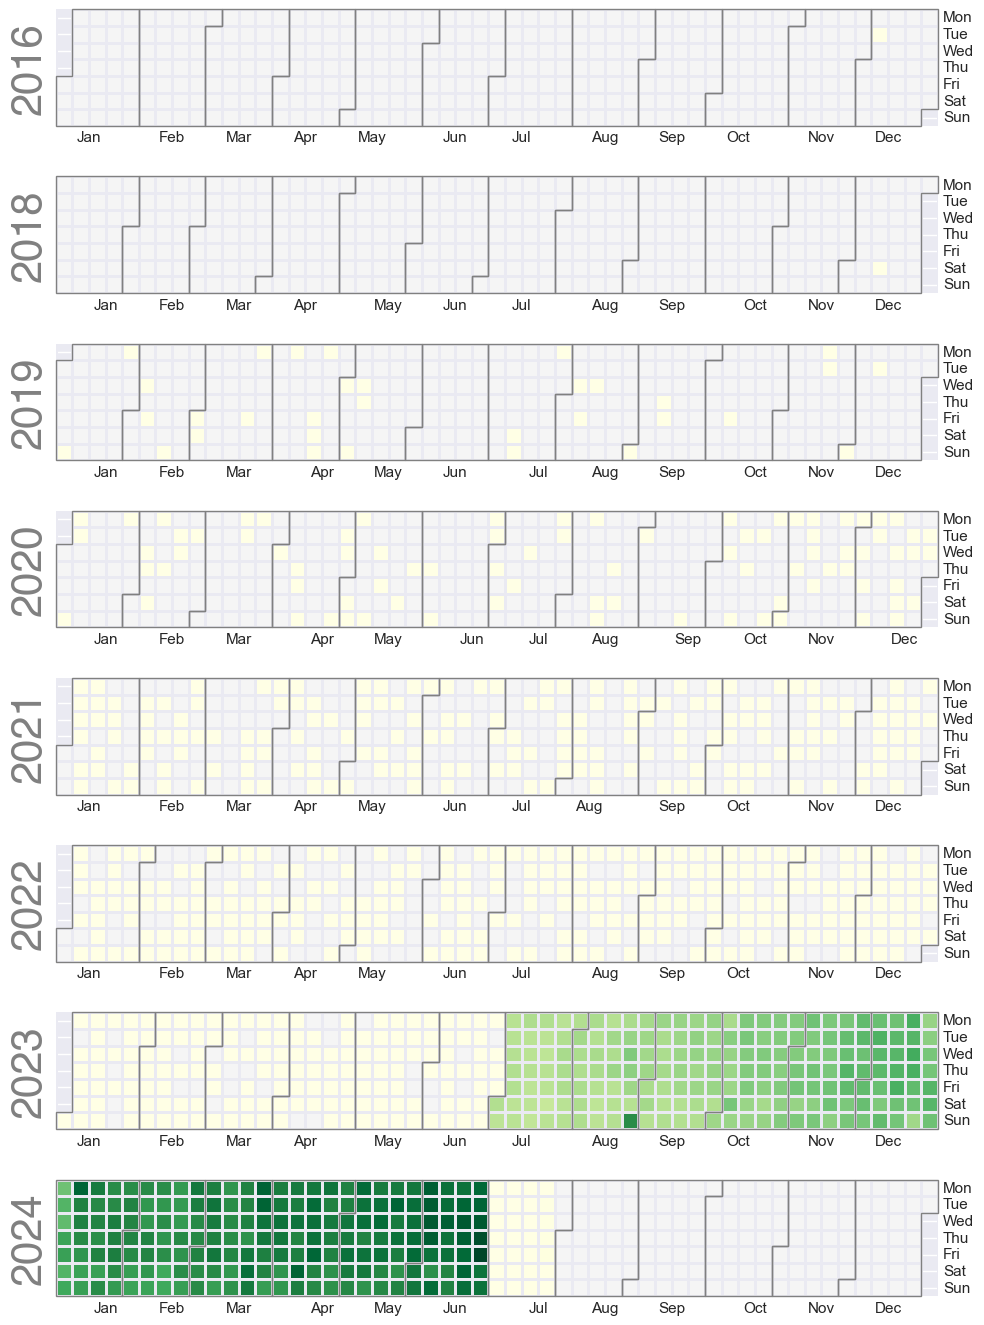

In [497]:
dates = pd.to_datetime(df["message_date"])

# Create a series with a date index and the message count for each date
messages_dates = dates.dt.date.value_counts().apply(lambda x: x/df.shape[0])
messages_dates.index = pd.to_datetime(messages_dates.index)

# visualize a data
calplot.calplot(messages_dates, cmap='YlGn', colorbar=False) 

**Findings:**
- As we can see, most messages were actually sent during the data-collection timeframe (July 2023 - July 2024).
- As expected, some messages were sent before the data collection timeframe. 
- The messages sent after the data collection period  will be dropped.

### 6. Verify Webpages

The column "urls" contains the urls of webpages referenced in a messages. To prepare them for further analysis down the line, we need to check if they adhere to valid url-formats.

To to so, we'll isolate invalid URLs and evaluate them manually.

In [498]:
# check, if urls are valid and save results in a list. If a message has no url, we consider it valid.
valid_url = df["webpage_url"].apply(lambda x: validators.url(x) if pd.notnull(x) else True) 

# As validator returns specific error messages, if a message is invalide, we need to replace them with False to use the filter in boolean indexing
invalid_url_filter = [False if elem == True else True for elem in valid_url]

df.loc[invalid_url_filter, ["webpage_url"]]

,webpage_url
69922,http://3.US-Militär/
171387,https://dna--awakening-org.translate.goog/are-...
199544,https://amg--news-com.translate.goog/seven-tru...
356868,https://off--guardian-org.translate.goog/2024/...
452060,https://rebelne.ws/4bhcfQL\
497550,https://amg--news-com.translate.goog/med-bed-l...
698101,https://amg--news-com.translate.goog/bombshell...
1610776,https://rebelne.ws/3F8sQs6\
1668014,https://rebelne.ws/3EPYYjQ\
1676697,https://www-renate--holzeisen-eu.cdn.ampprojec...


**Findings**

- Some of the urls contain backslashes, that should be removed.
- Some urls contain double dashes, which causes the url to be falsely flagged as invalid. These cases can be ignored.
- `http://3.US-Militär/	` is actually invalid and should be removed

### 7. Compare the Number of Messages per Chat

Last but not least, let us take a look at some descriptive statistics on how many messages were collected for each chat in our dataset. 

In [499]:
chats_message_counts = df.groupby("chat_name").size()
chats_message_counts.describe()

count     4969.000000
mean       394.404709
std       1585.022370
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      10002.000000
dtype: float64

**Min & Distribution:** As we can see, the distribution is highly skewed with the majority of chats containing 1 message, while a small number of chats make up a disproportionately large number of messages. This result is to be expected, as a quirk in the data collection process creates a lot of chats with only one message. 

**Max:** The maximum is 100002. This, again, is to be expected, as the data collection process was limited to collect a maximum of 10.000 messages per chat. The two additional messages are presumably messages originating from this chat, that were found as forwarded messages in another chat. In this case, the data-collection software creates an entry for both chats. 

**Conclusion**: As we need a certain amount of content and messages for the vectorisation of a chat, we should drop chats containing only few messages.

# Data Cleaning

During the initial exploration points we found the following tasks we need to adress before moving on to engineering the features for clustering:

- **Fix the faulty types.**

- **Drop `sender_display_name` and `post_author` columns**

- **Drop messages sent after the data collection period**

- **Clean urls (remove trailing backslashes and invalid links)**

- **Remove chats containing only few messages**


Optional tasks include:

- **(Optional) Delete duplicate rows**

- **(Optional) Aggregate datetime columns into broader time periods such as minutes, hours, days, or weeks.**

### 1. Clean Columns

First, we'll drop unnecessary columns and correct any faulty data types.

In [500]:
# drop columns
df.drop(labels=["sender_display_name","post_author"], axis=1, inplace=True)

# convert columns to datetime
df["collection_time"] = pd.to_datetime(df["collection_time"], errors='coerce')
df["message_date"] = pd.to_datetime(df["message_date"], errors='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1959797 entries, 0 to 1959796
Data columns (total 29 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   chat_handle              object        
 1   chat_name                object        
 2   chat_type                object        
 3   collection_time          datetime64[ns]
 4   fwd_from_chat_handle     object        
 5   fwd_from_user_name       object        
 6   is_fwd                   bool          
 7   is_group_elem            bool          
 8   is_reply                 bool          
 9   message_date             datetime64[ns]
 10  message_fwd_count        float64       
 11  message_group_id         float64       
 12  message_media_type       object        
 13  message_reactions        object        
 14  message_reactions_count  float64       
 15  message_text             object        
 16  message_view_count       float64       
 17  reply_to_message_id      fl

### 2. Drop Messages sent after the data collection period

Now we drop all messages that were sent after June 2024.

In [501]:
end_data_collection = pd.Timestamp(year=2024, month=6, day=30)
filter_outliers_date = df["message_date"].dt.date > end_data_collection.date()
df = df[~filter_outliers_date]
print(f"Messages sent after end of data collection left: {(df["message_date"].dt.date > end_data_collection.date()).sum()}")

Messages sent after end of data collection left: 0


### 3. Clean URLs

Now we can clean up the urls by removing backslashes and invalid urls.



In [502]:
# remove trailing backspaces
df["webpage_url"] = df["webpage_url"].str.replace("\\\\$", '', regex=True)

# remove the urls manually evaluated as invalid
invalid_urls = ["http://3.US-Militär/"]
df.loc[df["webpage_url"].isin(invalid_urls) , "webpage_url"] = ''

### 4. Drop duplicates

As we don't plan on using information on connection between messages, we can drop the duplicates. 

In [503]:
df = df.drop_duplicates()

### 5. Remove Chats containing only few messages

As we need a certain amount of content for the vectorisation and clustering of a chat, we'll drop those with fewer than 1000 available messages. 

Once we're done, we can check the message count statistics for improvements.

In [504]:
chats_message_counts = df.groupby("chat_name").size()
over_1000 = chats_message_counts[chats_message_counts > 1000]
over_1000_chat_names = list(over_1000.index)
df_over_1000 = df[df["chat_name"].isin(over_1000_chat_names)]

In [505]:
display(over_1000.describe())
print(f"Messages removed: {abs(df.shape[0] - df_over_1000.shape[0])}")
print(f"Chats removed: {abs(len(chats_message_counts)-len(over_1000))}")
print("")
print(f"Messages remaining: {df_over_1000.shape[0]}")
print(f"Chats remaining: {len(over_1000)}")

count      360.000000
mean      5024.275000
std       3369.241866
min       1013.000000
25%       1951.750000
50%       3908.500000
75%       8952.750000
max      10001.000000
dtype: float64

Messages removed: 147774
Chats removed: 3524

Messages remaining: 1808739
Chats remaining: 360


After removing 3524 chats containing 147774 messages, we're left with 360 chats with an average message count of 5024 and no fewer than 1013 messages.